# Fitting an ODE model to longitudinal data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sys
import os
import string
import pickle
from tqdm import tqdm
from datetime import datetime
#from lmfit import minimize, Parameters
#import multiprocess as mp

# Import my own libraries
sys.path.append('./utils')
import myUtils as utils
from odeModelClass import ODEModel
from odeModels import create_model
#from fittingUtils import residual, compute_r_sq, load_fit, generate_fitSummaryDf, perform_bootstrap, \
#                            compute_confidenceInterval_prediction, compute_confidenceInterval_parameters

### Cell cycle model

In [2]:
myModel = create_model("CellCycleModel")
myModel.SetParams(G10=1500*0.458, S0=1500*0.133, SD0=1500*0.0157, G20=1500*0.391, G2D0=1500*0.0023, Dead0=0, A10=0) #modify parameters
#myModel.SetParams(G10=0.01, S0=0, SD0=0, G20=0, G2D0=0, Dead0=0, A10=0) #modify parameters
myModel.Simulate(treatmentScheduleList=[[0,50,1,0],[50,100,0,1],[100,200,0.75,0.5],[200,300,0.5,0.75]])
# myModel.Simulate(treatmentScheduleList=[[0,320,0,0]], method="BDF")
myModel.Trim(dt=5.)
# myModel.Plot(plotPops=True)

[687.   199.5   23.55 586.5    3.45   0.     0.     1.     0.  ] 1
[687.   199.5   23.55 586.5    3.45   0.     0.     1.     0.  ] 2
[0. 0. 0. 0. 0. 0. 0. 0. 0.] 3
[6.87000254e+02 1.99499966e+02 2.35497126e+01 5.86499919e+02
 3.45018847e+00 2.44407052e-04 0.00000000e+00 1.00000000e+00
 0.00000000e+00] 1
[6.87000254e+02 1.99499966e+02 2.35497126e+01 5.86499919e+02
 3.45018847e+00 2.44407052e-04 0.00000000e+00 1.00000000e+00
 0.00000000e+00] 2
[0. 0. 0. 0. 0. 0. 0. 0. 0.] 3
[6.87001336e+02 1.99499823e+02 2.35484883e+01 5.86499576e+02
 3.45099137e+00 1.28558481e-03 0.00000000e+00 1.00000000e+00
 0.00000000e+00] 1
[6.87001336e+02 1.99499823e+02 2.35484883e+01 5.86499576e+02
 3.45099137e+00 1.28558481e-03 0.00000000e+00 1.00000000e+00
 0.00000000e+00] 2
[0. 0. 0. 0. 0. 0. 0. 0. 0.] 3
[6.87002003e+02 1.99499734e+02 2.35477326e+01 5.86499364e+02
 3.45148698e+00 1.92828444e-03 0.00000000e+00 1.00000000e+00
 0.00000000e+00] 1
[6.87002003e+02 1.99499734e+02 2.35477326e+01 5.86499364e+02
 3.4514

In [3]:
data_df_wide = myModel.resultsDf
variables_to_plot = ['G1', 'S', 'SD', 'G2', 'G2D', 'Dead', 'TumourSize']
data_df_long = pd.melt(data_df_wide, id_vars=['Time'], 
                  value_vars=myModel.stateVars + ["TumourSize"], 
                  var_name='Variable', value_name='Value')

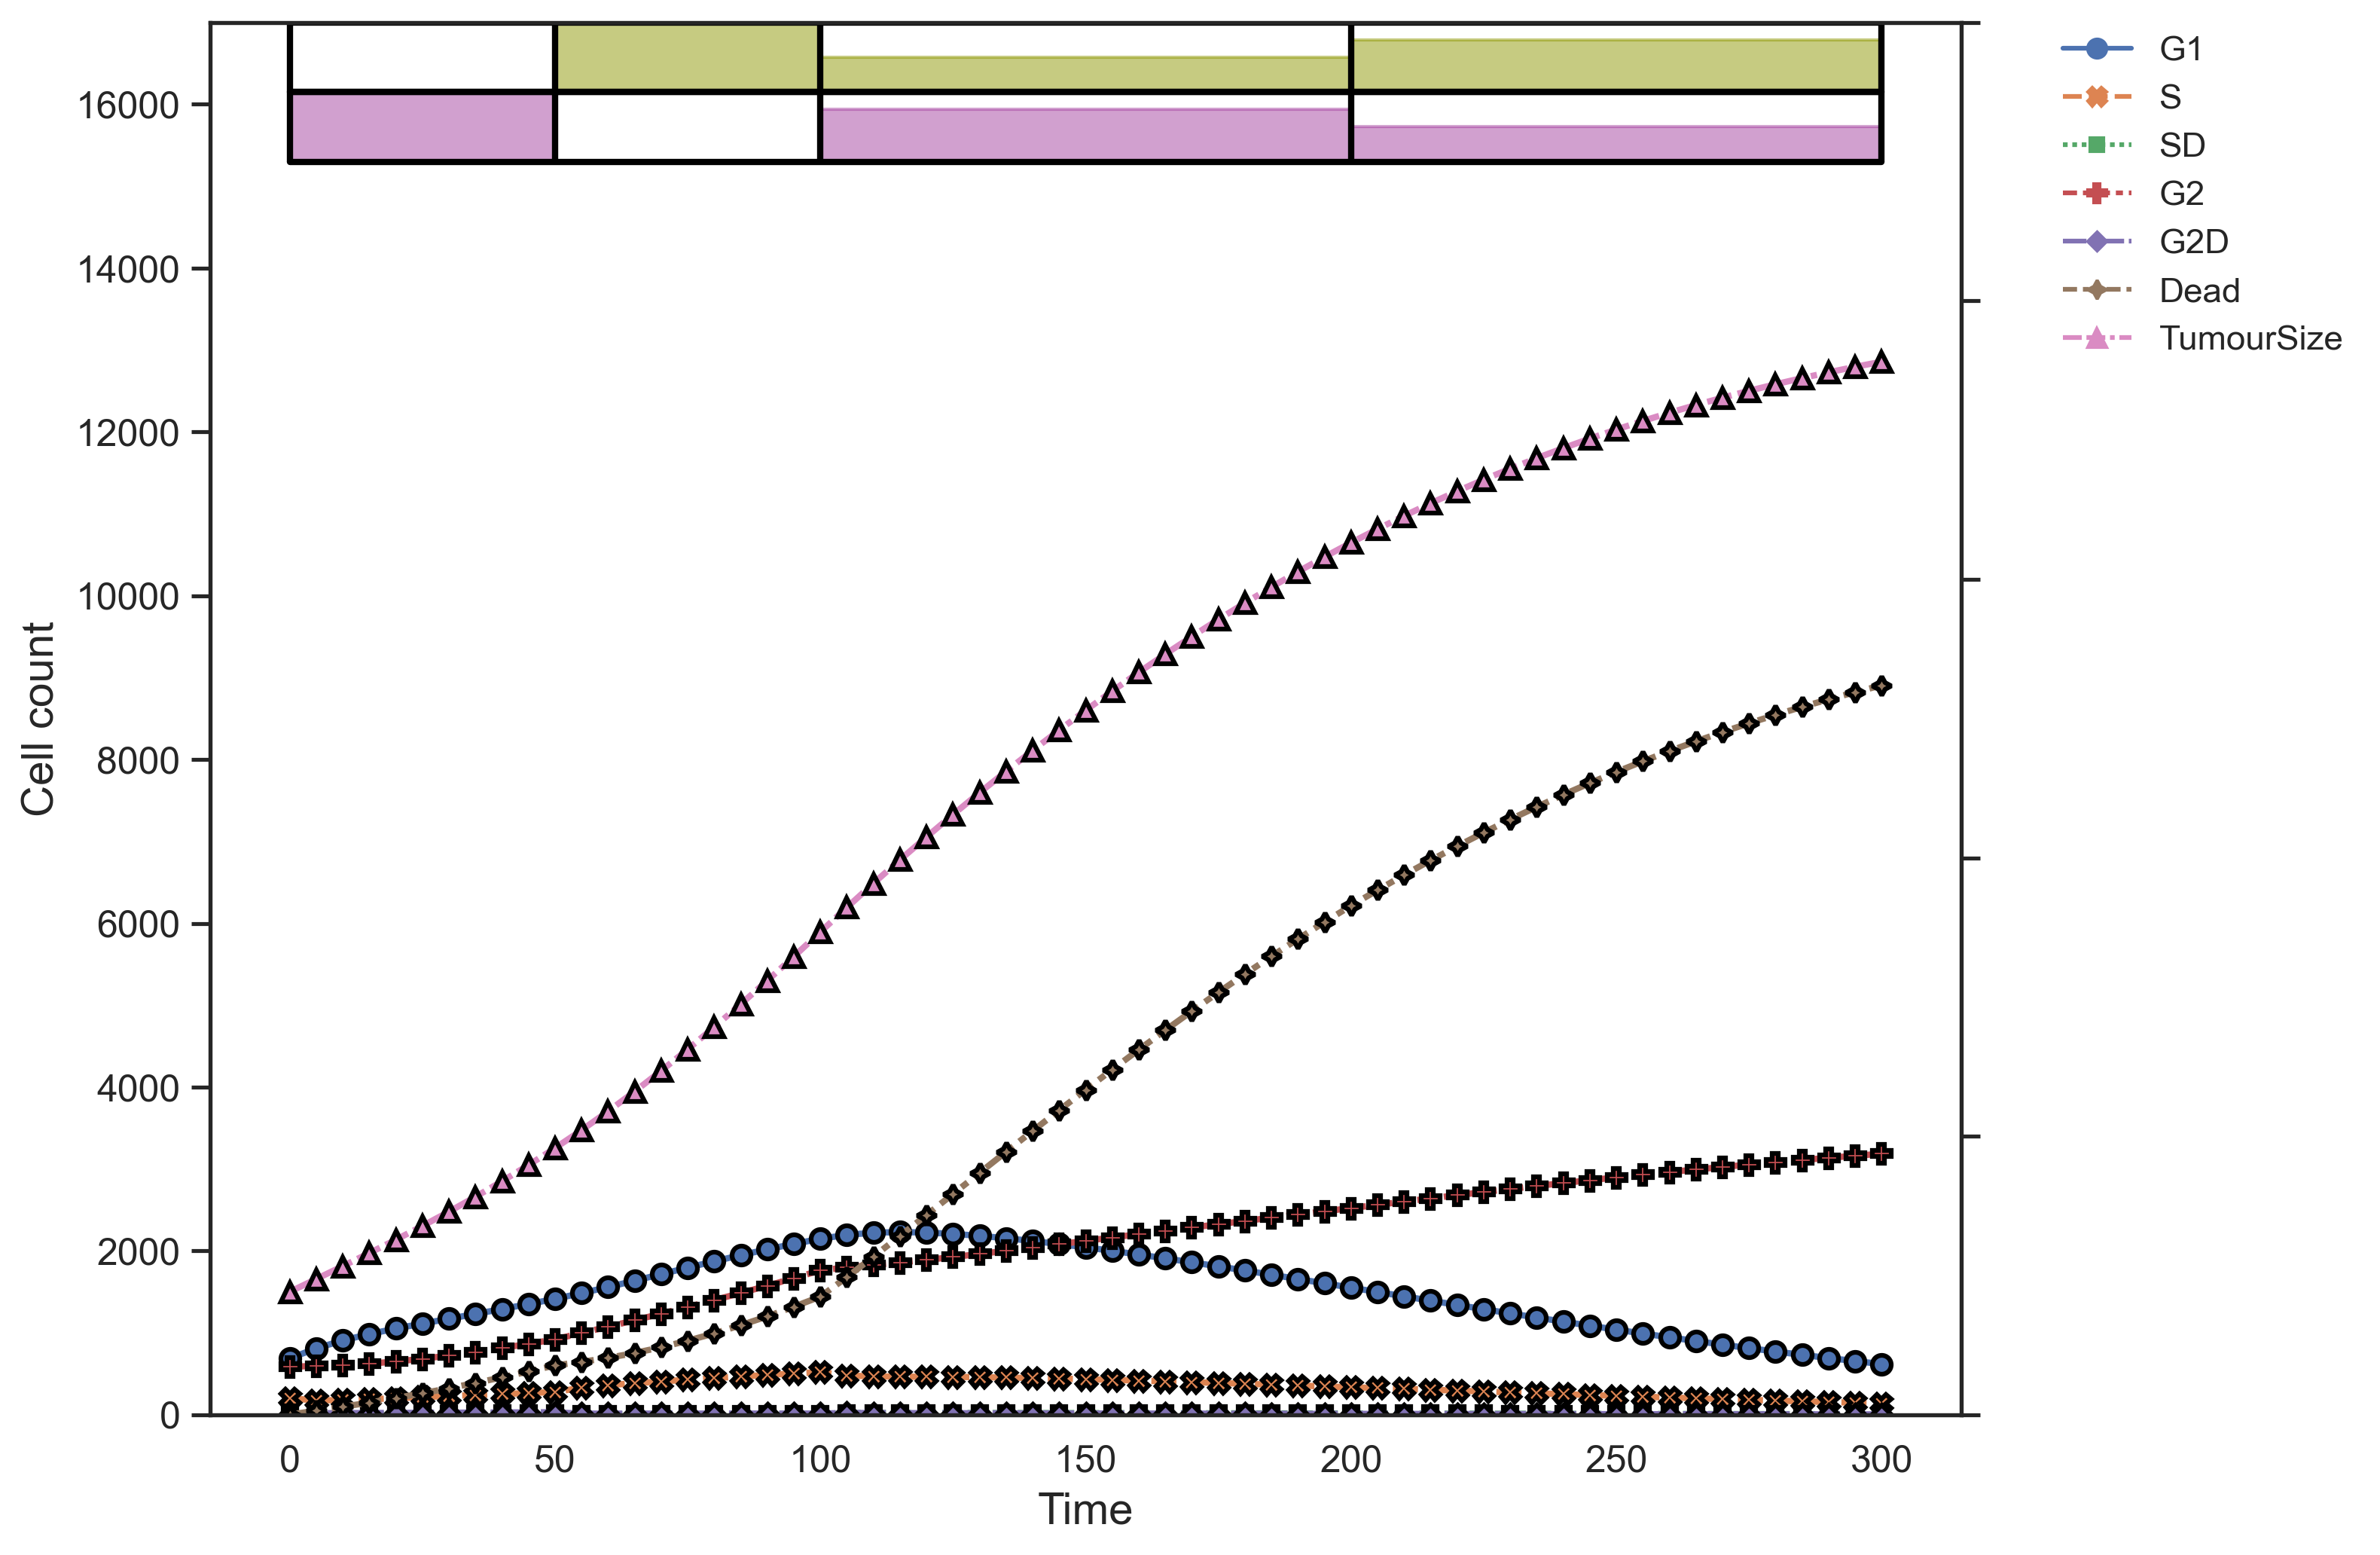

In [4]:
fig, ax = plt.subplots(1,1,figsize=(10,8), dpi=300)
sns.lineplot(
    x="Time", y="Value", hue="Variable", style="Variable",
    markers=True, linewidth=2, markersize=6, markeredgewidth=1.5,
    markeredgecolor='black', data=data_df_long[np.isin(data_df_long['Variable'], variables_to_plot)]
)

# Adjust the y-axis limit
ax.set_ylim([0, 17000])

# Move the legend outside the plot for better clarity
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., frameon=False)

# Clearer labels and ticks
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Cell count", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

# Add the drug concentration bar plot
utils.plot_drug_bar(
    drug_data_df=data_df_wide,
    drug_columns=["Drug1_Concentration", "Drug2_Concentration"],
    drug_bar_position=0.9, 
    drugBarColours=sns.xkcd_palette(['ugly purple', 'baby poop green']),
    ax=ax
)

plt.show()


In [9]:
data_df_wide

Time           G1           S         SD           G2        G2D  \
0     0.0   687.000000  199.500000  23.550000   586.500000   3.450000   
1     5.0   809.053365  175.481073   7.554026   590.683156  16.659169   
2    10.0   901.917538  176.874811   8.461087   589.995887  14.749924   
3    15.0   969.808569  186.976930   9.126971   589.441782  13.969629   
4    20.0  1019.733781  198.073875   9.615613   593.129737  13.474112   
5    25.0  1057.542360  207.809354   9.984301   600.421309  13.026970   
6    30.0  1087.154953  215.799265  10.272034   609.922232  12.589260   
7    35.0  1110.996618  222.256016  10.503082   620.527735  12.164861   
8    40.0  1130.534507  227.491364  10.692139   631.542429  11.762058   
9    45.0  1146.670860  231.769559  10.848208   642.578618  11.385399   
10   50.0  1159.986790  235.284617  10.977054   653.440364  11.035819   
11   55.0  1170.882003  238.173131  11.082610   664.040128  10.712145   
12   60.0  1179.651572  240.531866  11.167757   674.347757  10.412078   
13   65.0  1186.527349  242.431663  11.234746   684.361479  10.133436   
14   70.0  1191.700340  243.926741  11.285420   694.092944   9.873633   
15   75.0  1195.333126  245.060471  11.321347   703.559092   9.630682   
16   80.0  1197.567053  245.868866  11.343884   712.778612   9.402539   
17   85.0  1198.526722  246.382667  11.354227   721.769953   9.187691   
18   90.0  1198.322982  246.628643  11.353441   730.550766   8.984552   
19   95.0  1197.055098  246.630417  11.342477   739.137409   8.792058   
20  100.0  1194.812399  246.409035  11.322189   747.545059   8.609110   
21  105.0  1191.675586  245.983371  11.293352   755.787993   8.433792   
22  110.0  1187.717854  245.370439  11.256666   763.878268   8.267667   
23  115.0  1183.005721  244.585641  11.212767   771.828369   8.107799   
24  120.0  1177.599859  243.642962  11.162236   779.648821   7.954437   
25  125.0  1171.555716  242.555140  11.105604   787.349614   7.806798   
26  130.0  1164.924082  241.333809  11.043356   794.939811   7.664539   
27  135.0  1157.751580  239.989616  10.975938   802.427807   7.527113   
28  140.0  1150.081089  238.532331  10.903759   809.821271   7.394158   
29  145.0  1141.952114  236.970930  10.827198   817.127265   7.265281   
30  150.0  1133.401116  235.313683  10.746603   824.352259   7.140165   
31  155.0  1124.461801  233.568215  10.662296   831.502119   7.018769   
32  160.0  1115.165367  231.741573  10.574574   838.582420   6.900361   
33  165.0  1105.540746  229.840279  10.483715   845.597980   6.785297   
34  170.0  1095.614793  227.870376  10.389974   852.553507   6.672836   
35  175.0  1085.412479  225.837473  10.293590   859.453056   6.563182   
36  180.0  1074.957043  223.746782  10.194786   866.300527   6.455794   
37  185.0  1064.270151  221.603155  10.093766   873.099304   6.350779   
38  190.0  1053.372017  219.411110   9.990726   879.852547   6.247917   
39  195.0  1042.281528  217.174865   9.885845   886.563113   6.147024   
40  200.0  1031.016355  214.898357   9.779291   893.233526   6.048126   
41  205.0  1019.593046  212.585270   9.671222   899.866129   5.950965   
42  210.0  1008.027115  210.239053   9.561787   906.462973   5.855483   
43  215.0   996.333131  207.862938   9.451124   913.025876   5.761634   
44  220.0   984.524782  205.459959   9.339364   919.556463   5.669311   
45  225.0   972.614949  203.032967   9.226630   926.056163   5.578381   
46  230.0   960.615768  200.584644   9.113038   932.526186   5.488838   
47  235.0   948.538681  198.117516   8.998695   938.967577   5.400635   
48  240.0   936.394495  195.633963   8.883707   945.381236   5.313634   
49  245.0   924.193422  193.136234   8.768169   951.767870   5.227845   
50  250.0   911.945129  190.626452   8.652174   958.128065   5.143184   
51  255.0   899.658771  188.106629   8.535810   964.462243   5.059655   
52  260.0   887.343033  185.578666   8.419158   970.770715   4.977198   
53  265.0   875.006161  183.044370   8.302298   977.053678   4.

[687.   199.5   23.55 586.5    3.45   0.     0.     1.     0.  ] 1
[687.   199.5   23.55 586.5    3.45   0.     0.     1.     0.  ] 2
[0. 0. 0. 0. 0. 0. 0. 0. 0.] 3
[6.87000254e+02 1.99499966e+02 2.35497126e+01 5.86499919e+02
 3.45018847e+00 2.44407052e-04 0.00000000e+00 1.00000000e+00
 0.00000000e+00] 1
[6.87000254e+02 1.99499966e+02 2.35497126e+01 5.86499919e+02
 3.45018847e+00 2.44407052e-04 0.00000000e+00 1.00000000e+00
 0.00000000e+00] 2
[0. 0. 0. 0. 0. 0. 0. 0. 0.] 3
[6.87001336e+02 1.99499823e+02 2.35484883e+01 5.86499576e+02
 3.45099137e+00 1.28558481e-03 0.00000000e+00 1.00000000e+00
 0.00000000e+00] 1
[6.87001336e+02 1.99499823e+02 2.35484883e+01 5.86499576e+02
 3.45099137e+00 1.28558481e-03 0.00000000e+00 1.00000000e+00
 0.00000000e+00] 2
[0. 0. 0. 0. 0. 0. 0. 0. 0.] 3
[6.87002003e+02 1.99499734e+02 2.35477326e+01 5.86499364e+02
 3.45148698e+00 1.92828444e-03 0.00000000e+00 1.00000000e+00
 0.00000000e+00] 1
[6.87002003e+02 1.99499734e+02 2.35477326e+01 5.86499364e+02
 3.4514

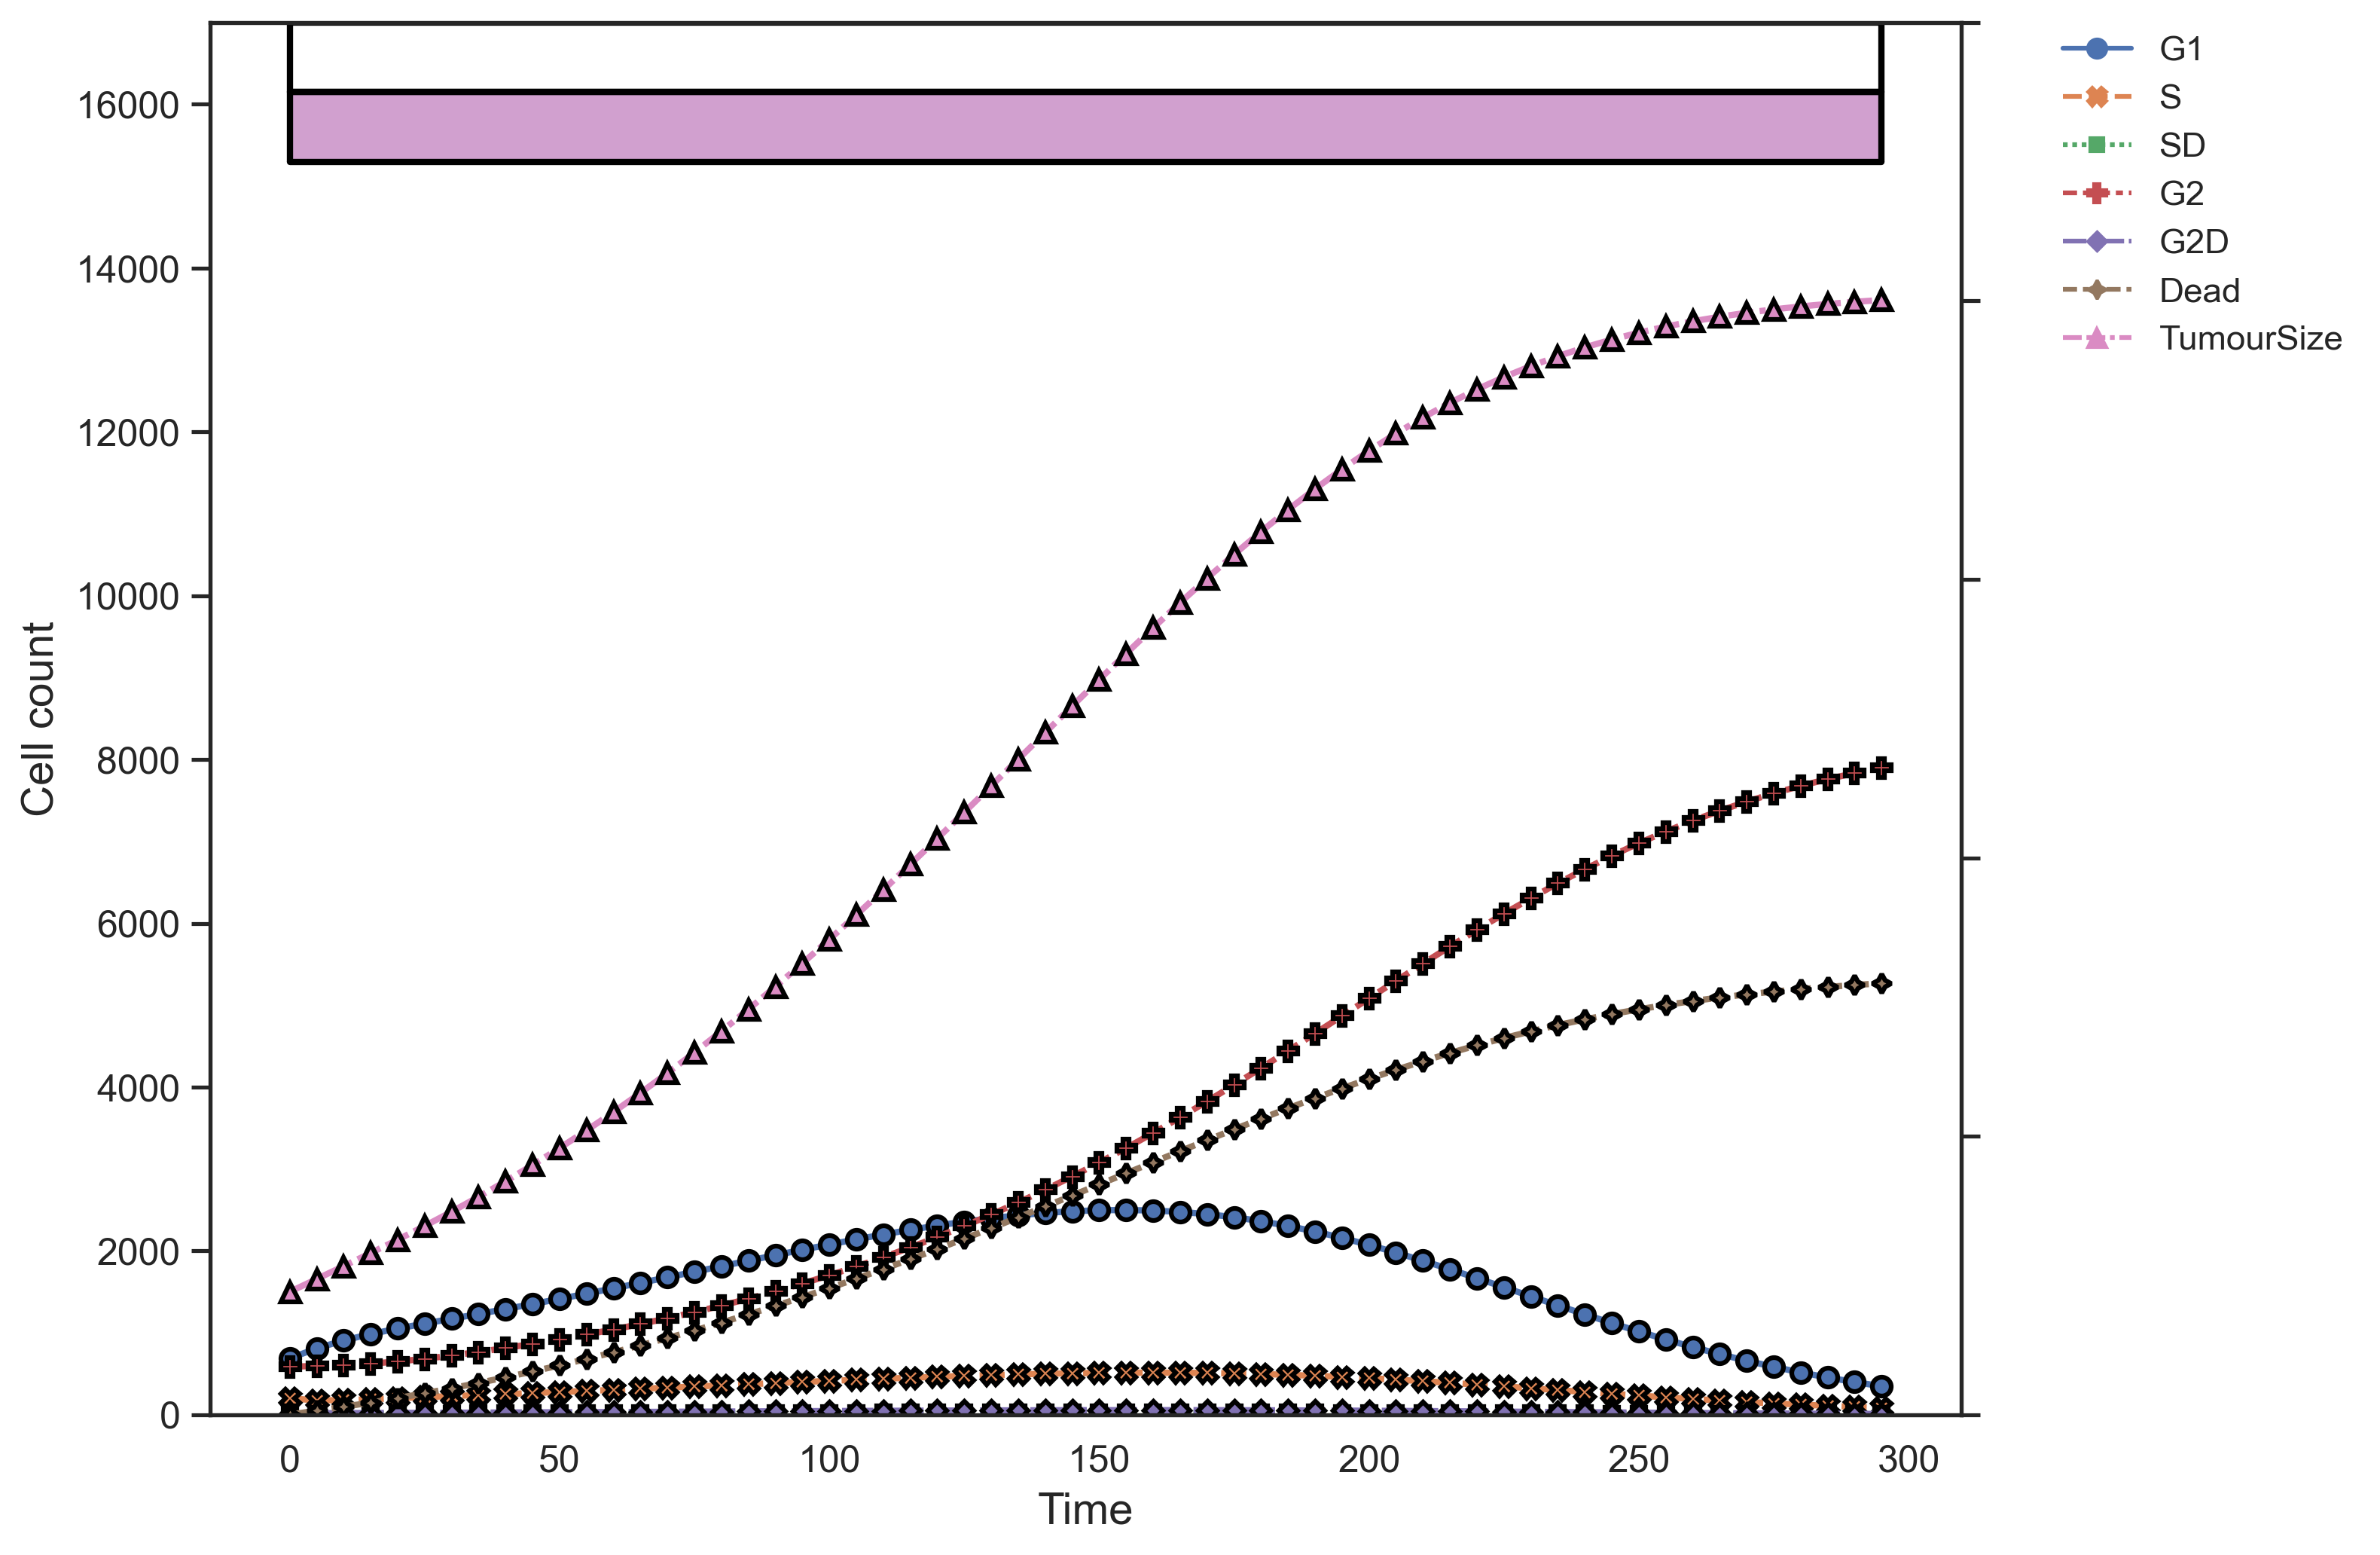

In [10]:
myModel = create_model("CellCycleModel")
myModel.SetParams(G10=1500*0.458, S0=1500*0.133, SD0=1500*0.0157, G20=1500*0.391, G2D0=1500*0.0023, Dead0=0, A10=0) #modify parameters
myModel.Simulate(treatmentScheduleList=[[0,300,1,0]])
myModel.Trim(dt=5.)

data_df_wide = myModel.resultsDf
variables_to_plot = ['G1', 'S', 'SD', 'G2', 'G2D', 'Dead', 'TumourSize']
data_df_long = pd.melt(data_df_wide, id_vars=['Time'], 
                  value_vars=myModel.stateVars + ["TumourSize"], 
                  var_name='Variable', value_name='Value')

fig, ax = plt.subplots(1,1,figsize=(10,8), dpi=300)
sns.lineplot(
    x="Time", y="Value", hue="Variable", style="Variable",
    markers=True, linewidth=2, markersize=6, markeredgewidth=1.5,
    markeredgecolor='black', data=data_df_long[np.isin(data_df_long['Variable'], variables_to_plot)]
)

# Adjust the y-axis limit
ax.set_ylim([0, 17000])

# Move the legend outside the plot for better clarity
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., frameon=False)

# Clearer labels and ticks
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Cell count", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

# Add the drug concentration bar plot
utils.plot_drug_bar(
    drug_data_df=data_df_wide,
    drug_columns=["Drug1_Concentration", "Drug2_Concentration"],
    drug_bar_position=0.9, 
    drugBarColours=sns.xkcd_palette(['ugly purple', 'baby poop green']),
    ax=ax
)

plt.show()

[687.   199.5   23.55 586.5    3.45   0.     0.     0.     1.  ] 1
[687.   199.5   23.55 586.5    3.45   0.     0.     0.     1.  ] 2
[0. 0. 0. 0. 0. 0. 0. 0. 0.] 3
[6.87000254e+02 1.99500029e+02 2.35496498e+01 5.86499959e+02
 3.45014898e+00 2.44407113e-04 2.72691350e-07 0.00000000e+00
 1.00000000e+00] 1
[6.87000254e+02 1.99500029e+02 2.35496498e+01 5.86499959e+02
 3.45014898e+00 2.44407113e-04 2.72691350e-07 0.00000000e+00
 1.00000000e+00] 2
[0. 0. 0. 0. 0. 0. 0. 0. 0.] 3
[6.87001336e+02 1.99500153e+02 2.35481578e+01 5.86499784e+02
 3.45078365e+00 1.28558513e-03 1.43436064e-06 0.00000000e+00
 1.00000000e+00] 1
[6.87001336e+02 1.99500153e+02 2.35481578e+01 5.86499784e+02
 3.45078365e+00 1.28558513e-03 1.43436064e-06 0.00000000e+00
 1.00000000e+00] 2
[0. 0. 0. 0. 0. 0. 0. 0. 0.] 3
[6.87002003e+02 1.99500230e+02 2.35472368e+01 5.86499676e+02
 3.45117535e+00 1.92826488e-03 2.15154016e-06 0.00000000e+00
 1.00000000e+00] 1
[6.87002003e+02 1.99500230e+02 2.35472368e+01 5.86499676e+02
 3.4511

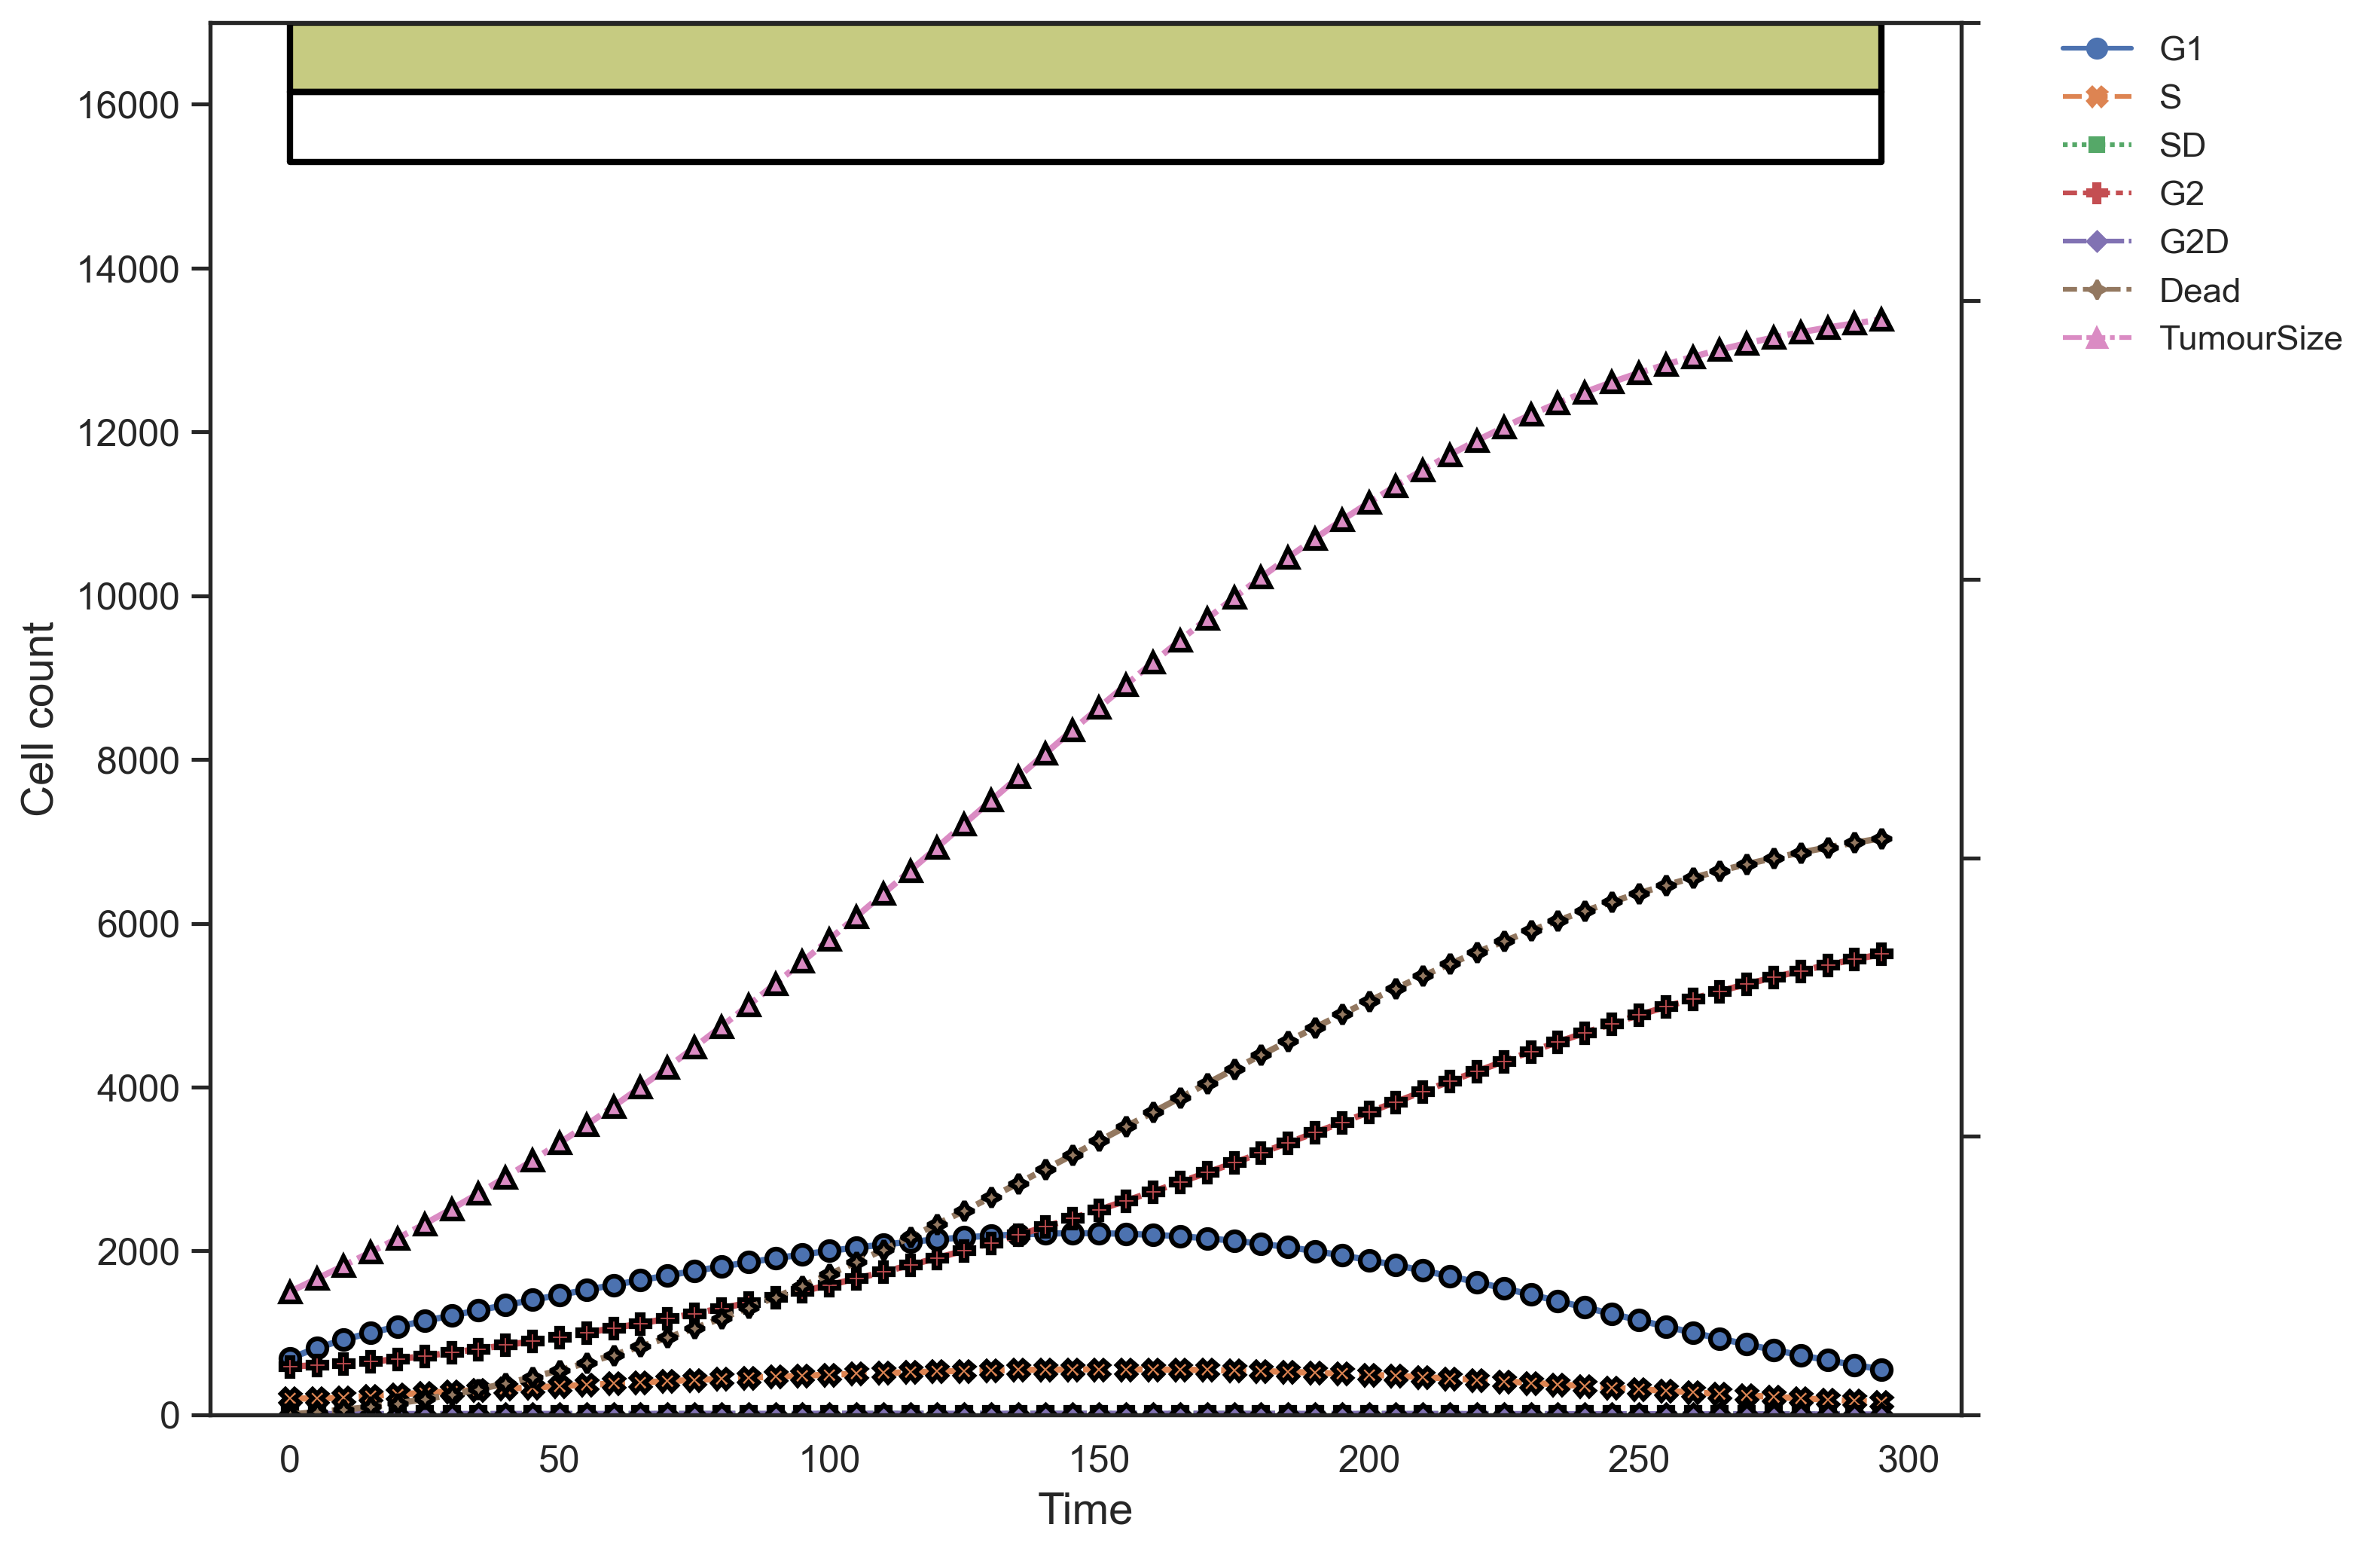

In [11]:
myModel = create_model("CellCycleModel")
myModel.SetParams(G10=1500*0.458, S0=1500*0.133, SD0=1500*0.0157, G20=1500*0.391, G2D0=1500*0.0023, Dead0=0, A10=0) #modify parameters
myModel.Simulate(treatmentScheduleList=[[0,300,0,1]])
myModel.Trim(dt=5.)

data_df_wide = myModel.resultsDf
variables_to_plot = ['G1', 'S', 'SD', 'G2', 'G2D', 'Dead', 'TumourSize']
data_df_long = pd.melt(data_df_wide, id_vars=['Time'], 
                  value_vars=myModel.stateVars + ["TumourSize"], 
                  var_name='Variable', value_name='Value')

fig, ax = plt.subplots(1,1,figsize=(10,8), dpi=300)
sns.lineplot(
    x="Time", y="Value", hue="Variable", style="Variable",
    markers=True, linewidth=2, markersize=6, markeredgewidth=1.5,
    markeredgecolor='black', data=data_df_long[np.isin(data_df_long['Variable'], variables_to_plot)]
)

# Adjust the y-axis limit
ax.set_ylim([0, 17000])

# Move the legend outside the plot for better clarity
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., frameon=False)

# Clearer labels and ticks
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Cell count", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

# Add the drug concentration bar plot
utils.plot_drug_bar(
    drug_data_df=data_df_wide,
    drug_columns=["Drug1_Concentration", "Drug2_Concentration"],
    drug_bar_position=0.9, 
    drugBarColours=sns.xkcd_palette(['ugly purple', 'baby poop green']),
    ax=ax
)

plt.show()

[687.   199.5   23.55 586.5    3.45   0.     0.     1.     1.  ] 1
[687.   199.5   23.55 586.5    3.45   0.     0.     1.     1.  ] 2
[0. 0. 0. 0. 0. 0. 0. 0. 0.] 3
[6.87000274e+02 1.99499964e+02 2.35496899e+01 5.86499913e+02
 3.45020335e+00 2.63699886e-04 2.94216797e-07 1.00000000e+00
 1.00000000e+00] 1
[6.87000274e+02 1.99499964e+02 2.35496899e+01 5.86499913e+02
 3.45020335e+00 2.63699886e-04 2.94216797e-07 1.00000000e+00
 1.00000000e+00] 2
[0. 0. 0. 0. 0. 0. 0. 0. 0.] 3
[6.87001441e+02 1.99499809e+02 2.35483691e+01 5.86499543e+02
 3.45106962e+00 1.38706541e-03 1.54758482e-06 1.00000000e+00
 1.00000000e+00] 1
[6.87001441e+02 1.99499809e+02 2.35483691e+01 5.86499543e+02
 3.45106962e+00 1.38706541e-03 1.54758482e-06 1.00000000e+00
 1.00000000e+00] 2
[0. 0. 0. 0. 0. 0. 0. 0. 0.] 3
[6.87002162e+02 1.99499713e+02 2.35475538e+01 5.86499314e+02
 3.45160435e+00 2.08049043e-03 2.32137630e-06 1.00000000e+00
 1.00000000e+00] 1
[6.87002162e+02 1.99499713e+02 2.35475538e+01 5.86499314e+02
 3.4516

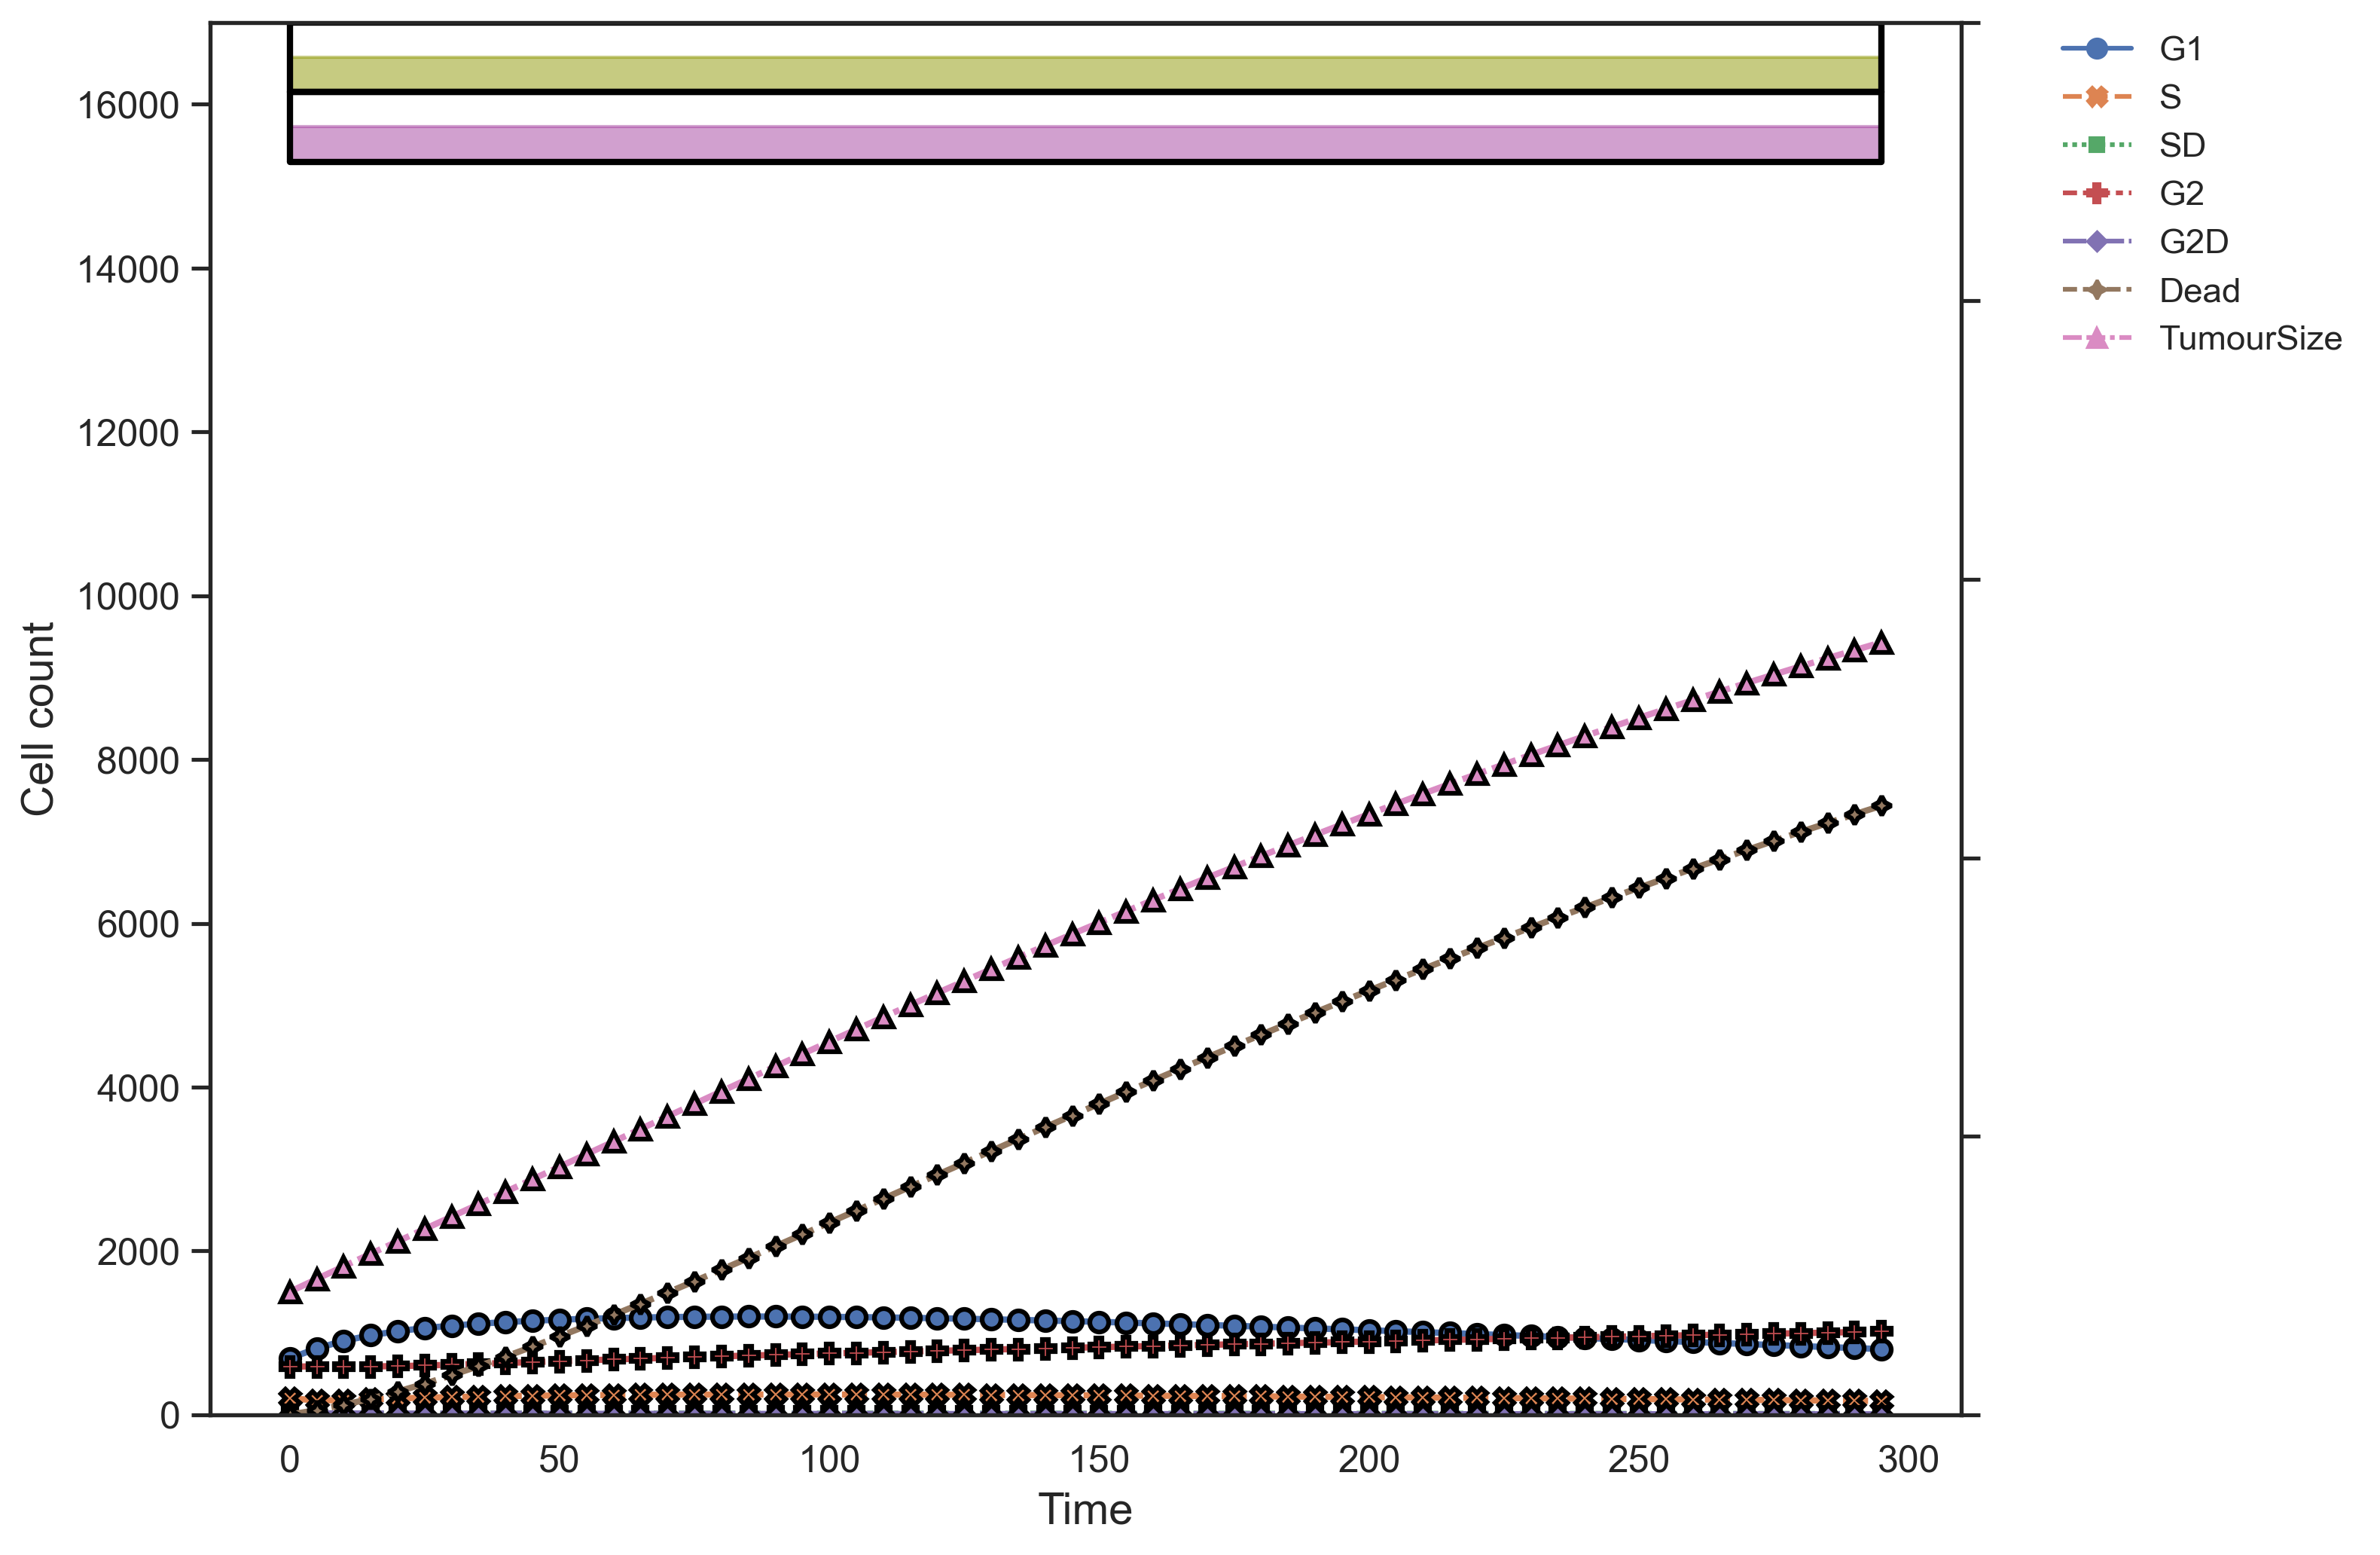

In [5]:
myModel = create_model("CellCycleModel")
myModel.SetParams(G10=1500*0.458, S0=1500*0.133, SD0=1500*0.0157, G20=1500*0.391, G2D0=1500*0.0023, Dead0=0, A10=0) #modify parameters
myModel.Simulate(treatmentScheduleList=[[0,300,1,1]])
myModel.Trim(dt=5.)

data_df_wide = myModel.resultsDf
variables_to_plot = ['G1', 'S', 'SD', 'G2', 'G2D', 'Dead', 'TumourSize']
data_df_long = pd.melt(data_df_wide, id_vars=['Time'], 
                  value_vars=myModel.stateVars + ["TumourSize"], 
                  var_name='Variable', value_name='Value')

fig, ax = plt.subplots(1,1,figsize=(10,8), dpi=300)
sns.lineplot(
    x="Time", y="Value", hue="Variable", style="Variable",
    markers=True, linewidth=2, markersize=6, markeredgewidth=1.5,
    markeredgecolor='black', data=data_df_long[np.isin(data_df_long['Variable'], variables_to_plot)]
)

# Adjust the y-axis limit
ax.set_ylim([0, 17000])

# Move the legend outside the plot for better clarity
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., frameon=False)

# Clearer labels and ticks
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Cell count", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

# Add the drug concentration bar plot
utils.plot_drug_bar(
    drug_data_df=data_df_wide,
    drug_columns=["Drug1_Concentration", "Drug2_Concentration"],
    drug_bar_position=0.9, 
    max_dose=[2,2],
    drugBarColours=sns.xkcd_palette(['ugly purple', 'baby poop green']),
    ax=ax
)

plt.show()